In [512]:
%run 'Functions.ipynb'

# 1. Extracting fitness potential

In [617]:
min_max_scaler = MinMaxScaler()
n_iter = 1000

chunk = 'S2'
print (chunk)
data, labels, unique_mutations[chunk], aa_seq = read_data_all_positions(chunk)

scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))

x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.01)

model = Sequential()

model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer='glorot_normal'))
model.add(Dense(2, activation='sigmoid', kernel_initializer='glorot_normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer=opt,
              loss='mean_squared_error',
              verbose=0)

hist = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                        epochs=n_iter, batch_size=500, shuffle=True, verbose=0)

proba = model.predict_proba(data, batch_size=500, verbose=0)

weights = model.layers[0].get_weights()[0]
biases = model.layers[0].get_weights()[1]

true = labels
predicted = min_max_scaler.inverse_transform(proba)
predicted = predicted.flatten()
fitness_potential = data.dot(weights) + biases

S2


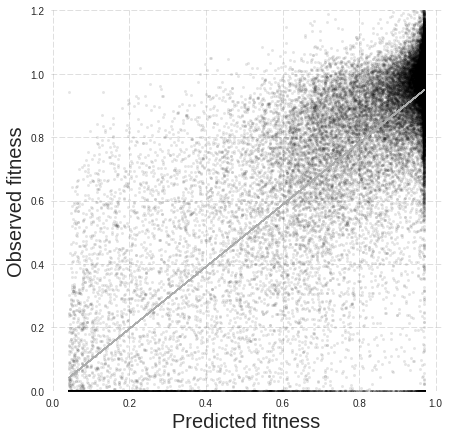

In [618]:
plt.figure(figsize = [7,7])
y = true
x = predicted
plt.ylim(0,1.2)

x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x, y)

plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
plt.plot(x, y,'ok',alpha=0.1, ms=3)
plt.plot(x, a*x, '#abacac', lw=1, alpha=1)
plt.xlabel('Predicted fitness', fontsize=20)
plt.ylabel('Observed fitness', fontsize=20);

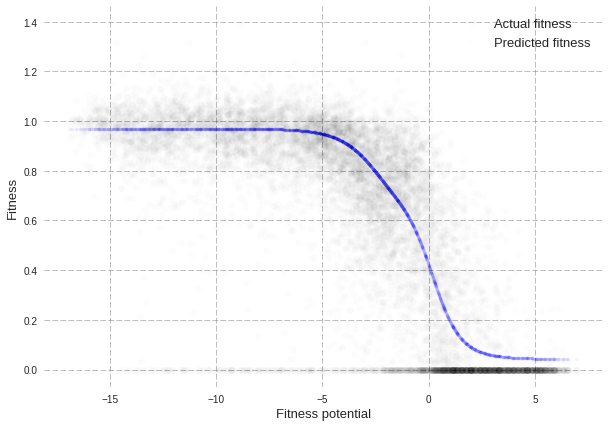

In [619]:
plt.figure(figsize = [10,7])
plt.plot(fitness_potential[:10000], true[:10000], 'ok', alpha = 0.01, label='Actual fitness');
plt.plot(fitness_potential[:10000], predicted[:10000], '.b', alpha = 0.01, label='Predicted fitness')
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.xlabel('Fitness potential',fontsize=13)
plt.ylabel('Fitness',fontsize=13)
plt.legend(fontsize=13);

In [620]:
_,_,R,_,_ = stats.linregress(predicted,labels.flatten())
print chunk, '\t', R**2

S2 	0.703347336731


# 2. Creating fake fitness and trying to predict it

In [645]:
fake_fitness = fitness_potential*np.sin(fitness_potential)

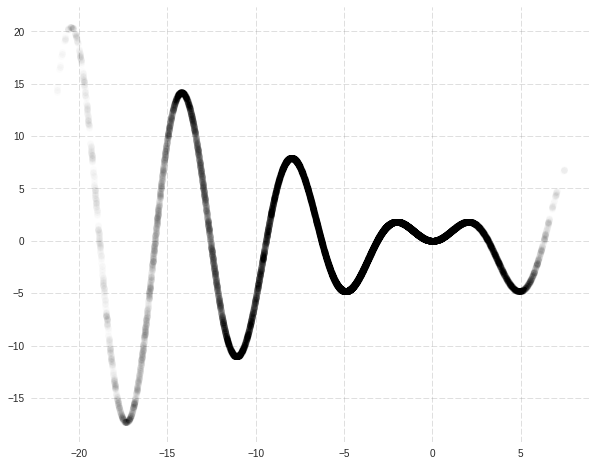

In [646]:
plt.figure(figsize=[10,8])
plt.plot(fitness_potential, fake_fitness,'ok',alpha=.01)
plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray');

In [623]:
min_max_scaler = MinMaxScaler()
n_iter = 1000

scaled_fake_fitness = min_max_scaler.fit_transform(fake_fitness.reshape(-1,1))

x_train, x_valid, y_train, y_valid = train_test_split(data, scaled_fake_fitness, test_size = 0.01)

model = Sequential()

model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer='glorot_normal'))
model.add(Dense(2, activation='sigmoid', kernel_initializer='glorot_normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.001)

model.compile(optimizer=opt,
              loss='mean_squared_error',
              verbose=0)

hist = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                        epochs=n_iter, batch_size=500, shuffle=True, verbose=0)

fake_proba = model.predict_proba(data, batch_size=500, verbose=0)

fake_weights = model.layers[0].get_weights()[0]
fake_biases = model.layers[0].get_weights()[1]

fake_predicted = min_max_scaler.inverse_transform(fake_proba)
fake_predicted = fake_predicted.flatten()
fake_fitness_potential = data.dot(fake_weights) + fake_biases

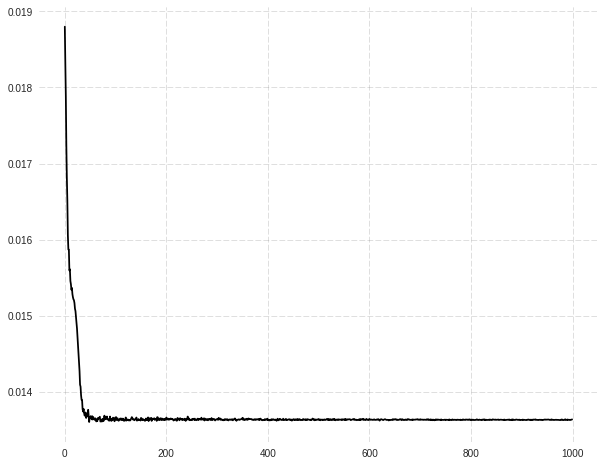

In [624]:
plt.figure(figsize=[10,8])
plt.plot([x for x in range(len(hist.history['val_loss']))],hist.history['val_loss'],'k')
plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray');

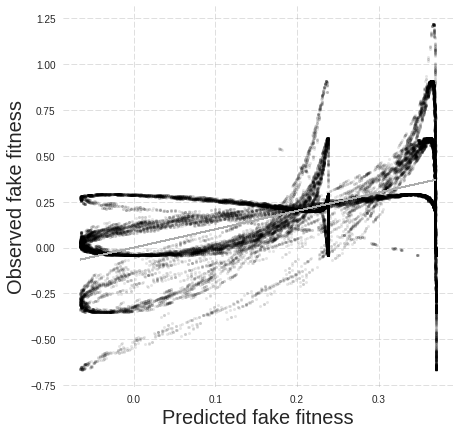

In [625]:
plt.figure(figsize = [7,7])
y = fake_fitness
x = fake_predicted
# plt.ylim(0,1.2)

x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x, y)

plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
plt.plot(x, y,'ok',alpha=0.1, ms=3)
plt.plot(x, a*x, '#abacac', lw=1, alpha=1)
plt.xlabel('Predicted fake fitness', fontsize=20)
plt.ylabel('Observed fake fitness', fontsize=20);

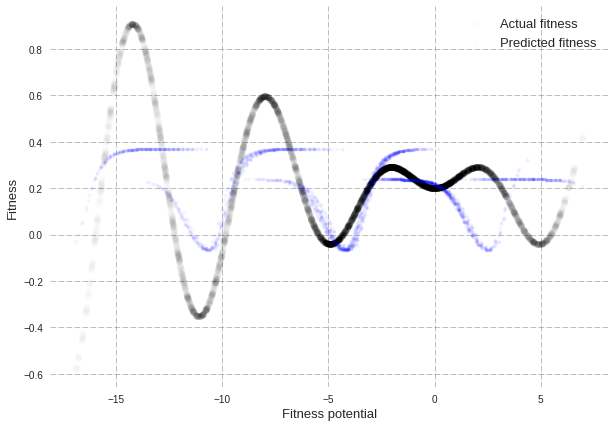

In [626]:
plt.figure(figsize = [10,7])
plt.plot(fitness_potential[:10000], fake_fitness[:10000], 'ok', alpha = 0.01, label='Actual fitness');
plt.plot(fitness_potential[:10000], fake_predicted[:10000], '.b', alpha = 0.01, label='Predicted fitness')
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.xlabel('Fitness potential',fontsize=13)
plt.ylabel('Fitness',fontsize=13)
plt.legend(fontsize=13);

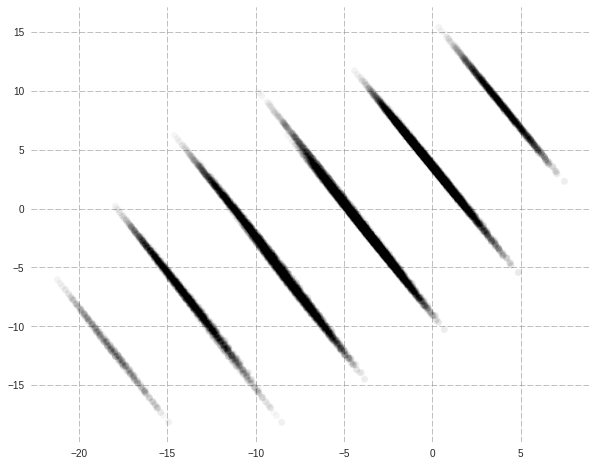

In [627]:
plt.figure(figsize=[10,8])
plt.plot(fitness_potential, fake_fitness_potential, 'ok', alpha=0.01)
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray');

In [628]:
_,_,R,_,_ = stats.linregress(fake_predicted,fake_fitness.flatten())
print chunk, '\t', R

S2 	0.523942836741


# 3. Predicting with a sigmoid perceptron

In [526]:
min_max_scaler = MinMaxScaler()
n_iter = 1000

print (chunk)
data, labels, unique_mutations[chunk], aa_seq = read_data_all_positions(chunk)

scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))

x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.01)

model = Sequential()

model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer='glorot_normal'))

opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer=opt,
              loss='mean_squared_error',
              verbose=0)

hist = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                        epochs=n_iter, batch_size=500, shuffle=True, verbose=0)

proba = model.predict_proba(data, batch_size=500, verbose=0)

weights = model.layers[0].get_weights()[0]
biases = model.layers[0].get_weights()[1]

true = labels
predicted = min_max_scaler.inverse_transform(proba)
predicted = predicted.flatten()
fitness_potential = data.dot(weights) + biases

S3


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize = [7,7])
y = true
x = predicted
plt.ylim(0,1.2)

x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x, y)

plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
plt.plot(x, y,'ok',alpha=0.1, ms=3)
plt.plot(x, a*x, '#abacac', lw=1, alpha=1)
plt.xlabel('Predicted fitness', fontsize=20)
plt.ylabel('Observed fitness', fontsize=20);

In [ ]:
plt.figure(figsize = [10,7])
plt.plot(fitness_potential[:10000], true[:10000], 'ok', alpha = 0.01, label='Actual fitness')
plt.plot(fitness_potential[:10000], predicted[:10000], '.b', alpha = 0.01, label='Predicted fitness')
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.xlabel('Fitness potential',fontsize=13)
plt.ylabel('Fitness',fontsize=13)
plt.legend(fontsize=13);

---

# A) For Reviewer 1

In order to optimize the accuracy/overfitting ratio, we tried over a hundred different neural network architectures and parameters. As a starting point, we came up with several complicated architectures, which described our data properly but were prone to overfitting due to a huge number of parameters. Then, we were gradually reducing the number of layers and neurons in order to reduce the overfitting, while controlling for accuracy.

It is important to mention here that a substantial fraction of the tested architectures, despite the potential complexity of the resulting models, gave rise to sigmoid-like functions:

FIGURE

Moreover, using other activation functions, like rectified linear unit or hyperbolic tangent, gave us similar results:

FIGURE

Our resulting architecture consists of three layers and 4 neurons in total (please see ED Figure 4). Each of the neurons performs a linear transformation of the input and subsequently applies a non-linear activation function (a sigmoid) to the result. The output of the first layer, therefore, is a sigmoid of a linear transformation of the feature vectors ($\textbf{w}^Tx + b$). The second layer decompresses the hidden nonlinear representation into 2 sigmoids, the combination of which is further linearly transformed with the only neuron of the third layer and wrapped into another sigmoid function:

$ F(x) = \sigma(w_{3,1}\sigma(w_{2,1}\sigma(\textbf{w}_1^Tx + b_1) + b_{2,1}) + w_{3,2}\sigma(w_{2,2}\sigma(\textbf{w}_1^Tx + b_1) + b_{2,2}) + b_3) $

where $\sigma(t) = \frac{1}{(1+exp(-t))}$, $x$ - feature vector, $\textbf{w}_1$ - vector of weights, correponding to the first layer, $w_{n,k}$ - weight corresponding to the $n$-th layer and the $k$-th neuron, $b_n$ - bias corresponding to the $n$th layer.

This architecture is capable of giving rise not only to sigmoid shapes, but also  

The proposed single-node single-layer neural net, on the other hand, would give rise to a function of the following shape:

$F(x) = \frac{1}{(1+exp(-\textbf{w}^Tx - b))}$

And since in deep learning the weights and the biases are the only optimized parameters, there are simply not enough degrees of freedom to describe our data:

FIGURE


We selected a deep learning approach, since neural networks can generally compute any function at all. There is only a handful of the classical activation functions used (and sigmoid is one of them), nevertheless, that is enough to construnct functions of any complexity. The reason we emphasize the sigmoidal shape therefore is that despite the potential complexity, for 10 out of 12 segments and for the majority of architectures tested, neural networks used a sigmoidal shape to describe our data.